# Detecting the month by Outgoing Longwave Radiation (OLR)

Outgoing Long-wave Radiation [(OLR)](https://en.wikipedia.org/wiki/Outgoing_longwave_radiation) is electromagnetic radiation of wavelengths between 3 and 100 µm emitted from Earth and its atmosphere out to space in the form of thermal radiation. It is a measure of the amount of energy emitted to space by earth's surface, oceans and atmosphere and is a critical component of the earth's radiation budget. OLR observations are made via the Advanced Very High Resolution Radiometer (AVHRR) instrument aboard the NOAA polar orbiting spacecraft and can be obtained [here](https://www.esrl.noaa.gov/psd/data/gridded/data.interp_OLR.html).

OLR has a dominant meridional (North - South) annual cycle as it moves from summer to winter and viceversa. 
OLR is also affected by short term day to day variability as well as long term decadal events. Here I have taken the OLR daily data for 39 years (1979-2017) and have attempted to detect the month to whuich the data belongs by using a deep neural network.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import keras
import xarray
plt.ion()
seaborn.set_style('whitegrid',rc={"axes.edgecolor":'black'})

Using TensorFlow backend.


In [2]:
def extractData(filePath,var, yearMin, yearMax):
    data = xarray.open_dataset(filePath)
    tm = data.time.dt.year
    out = data[var]
    out = out[(tm >= yearMin) & (tm <= yearMax)]
    return out 

In [3]:
olr = extractData('Data/olr.day.mean.nc', 'olr', 1979, 2017)
month = olr.time.dt.month

The OLR data for the 15th of every month is plotted below.
From the naked eye its very difficult to differentiate the months. 
Feel free to change the year and experiment. Download the data and put in the Data folder.

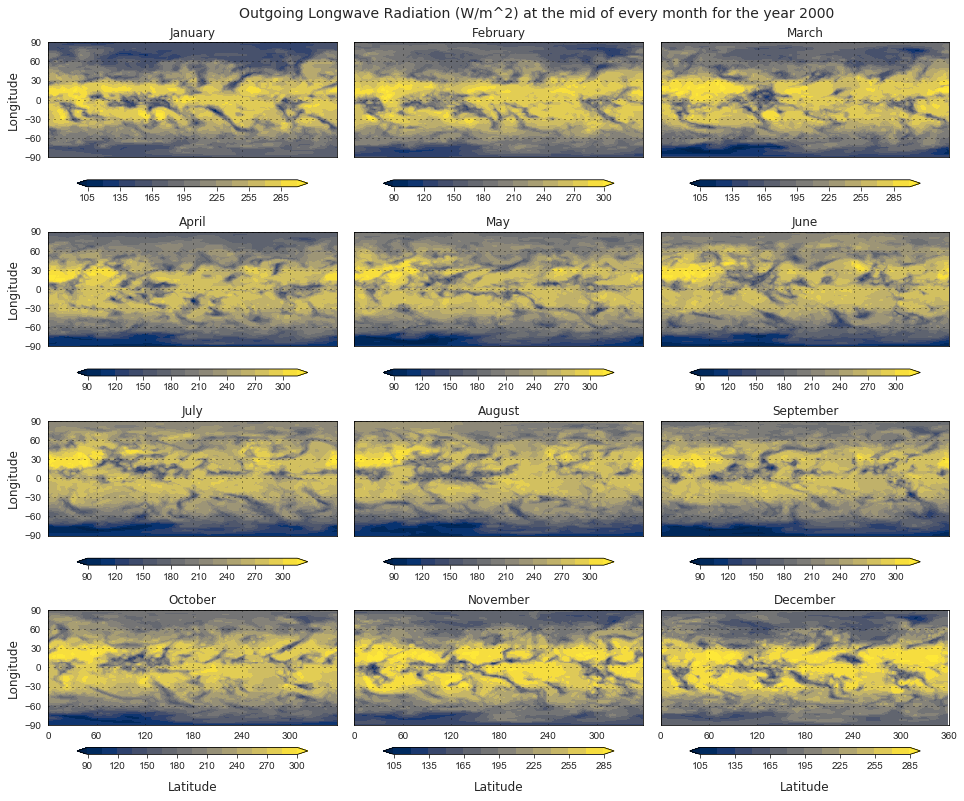

In [4]:
import calendar
fig,ax = plt.subplots(4,3, sharey='all',sharex='all',figsize=(15,12 ))
ax = ax.flatten()
plotVar = olr[olr.time.dt.year == 2000] # change the year if you want
lats = olr.lat
lons = olr.lon

for i in range(12):
    contours = ax[i].contourf(lons,lats,plotVar[15+30*i],16, cmap='cividis',extend='both',zorder=0)
    plt.colorbar(contours,ax=ax[i], orientation='horizontal',shrink=0.8,aspect=30,pad=0.14)
    ax[i].grid(alpha=0.7,color='k',linestyle='dotted',dashes=[1,5 ],linewidth=1,zorder=10)
    ax[i].set_xticks(np.linspace(0,360,7))
    ax[i].set_yticks(np.linspace(-90,90,7))
    ax[i].set_title(calendar.month_name[i+1],size='12', fontname = 'Dejavu Sans')

for j in range(4):
    ax[3*j].set_ylabel('Longitude',size='12', fontname = 'Dejavu Sans')    
for j in range(3):
    ax[9+j].set_xlabel('Latitude',size='12', fontname = 'Dejavu Sans',labelpad=40)

plt.suptitle("Outgoing Longwave Radiation (W/m^2) at the mid of every month for the year 2000",
             size='14', fontname = 'Dejavu Sans')
fig.tight_layout(rect=[0, 0.05, 0.9, 0.97])

I have Keras to build a densely connected network. The output (month names) have been transformed by an one hot encoding process. 25% of the data has been randomly selected for testing.

In [5]:
from keras.utils import to_categorical 
from sklearn.model_selection import train_test_split

X = olr.data
X = X.reshape((X.shape[0], X.shape[1], X.shape[2], 1))
Y = to_categorical(month-1)
assert len(X) == len(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=23)

print ("n_train =", len(X_train))
print ("n_test =", len(X_test))

n_train = 10683
n_test = 3562


In [6]:
# normalisation
Xmean = np.mean(X_train)
Xstd  = np.std(X_train)
X_train = (X_train - Xmean)/Xstd
X_test  = (X_test  - Xmean)/Xstd

Have done a rough grid search and selected the optimal values. 
Fine tuning would probably improve the predictions even better.

In [7]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam, RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(X.shape[1],X.shape[2],1)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(12, activation='softmax'))
model.summary()
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=25, batch_size=64, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 10512)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1345664   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                396       
Total params: 1,350,188
Trainable params: 1,350,188
Non-trainable params: 0
_________________________________________________________________


(0, 25)

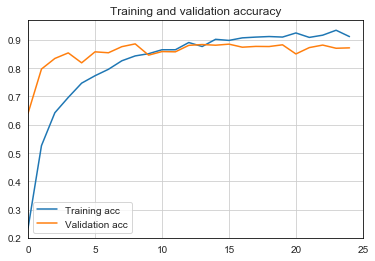

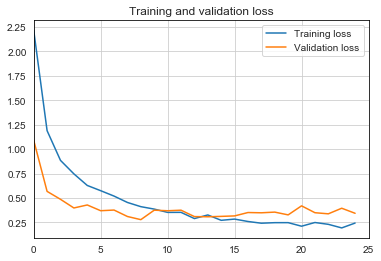

In [8]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlim(0,len(acc))

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlim(0,len(acc))

In [9]:
loss, accuracy = model.evaluate(X_test, Y_test)
print ("Loss:", loss)
print ("Accuracy:", accuracy)

3562/3562 [==============================] - 0s 91us/step
Loss: 0.3289086726158941
Accuracy: 0.8801235261423945


Test data has an accuracy of about 88%.  Now we will have a look at the [confusion matrix   ](https://www.geeksforgeeks.org/confusion-matrix-machine-learning/) which gives a better insight of the model performance.

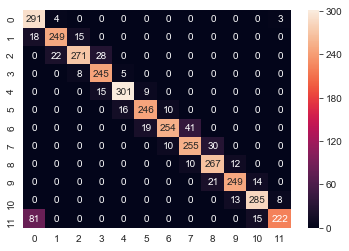

In [10]:
from sklearn.metrics import confusion_matrix
Y_pred = model.predict(X_test)
Y_pred1 = np.argmax(Y_pred, axis=1)
Y_test1 = np.argmax(Y_test, axis=1)
cmat =  confusion_matrix(Y_test1,Y_pred1)
seaborn.heatmap(cmat, annot=True,fmt='g')

Almost all the misclassification is between the neighbouring months. 
This is expected as for eg. the Jan 30th and Feb 2nd would have similar OLR signature but would be classified as different months. Keeping this in mind we can conclude that the model performs very well in classifying the months.